# 石油化工行业碳排放预测模型

本模型使用 XGBoost 机器学习算法，基于石油化工行业的相关数据预测碳排放量。

In [91]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display

# 导入自定义函数
from utils import PetrochemicalEmissions

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 1. 数据加载与预处理

In [92]:
# 读取数据
df = pd.read_csv("./datasets/石油化工.csv")
df.head()

,企业,化石燃料活动水平,化石燃料排放因子,碳排放量
0,中国石化-镇海炼化（浙江）,"1,200 (原油)",3.15,"3,780.00"
1,中国石油-大庆石化（黑龙江）,950 (原油),3.15,"2,992.50"
2,恒力石化-大连长兴岛（辽宁）,"1,500 (原油)",3.15,"4,725.00"
3,中国海油-惠州炼化（广东）,"1,100 (原油)",3.10,"3,410.00"
4,荣盛石化-舟山基地（浙江）,"1,800 (原油)",3.15,"5,670.00"


In [93]:
# 数据预处理函数 - 去除括号及括号内内容
def clean_brackets(text):
    if isinstance(text, str):
        # 去除括号及其中文内容
        return re.sub(r"\([^)]*\)", "", text).strip()
    return text


# 去除数字中的逗号
def remove_commas(text):
    if isinstance(text, str):
        return text.replace(",", "")
    return text

In [94]:
# 应用预处理函数
df_clean = df.copy()

# 处理化石燃料活动水平列
df_clean["化石燃料活动水平"] = df_clean["化石燃料活动水平"].apply(remove_commas)
df_clean["化石燃料活动水平"] = df_clean["化石燃料活动水平"].apply(clean_brackets)
df_clean["化石燃料活动水平"] = pd.to_numeric(df_clean["化石燃料活动水平"])

# 处理化石燃料排放因子列
df_clean["化石燃料排放因子"] = df_clean["化石燃料排放因子"].apply(clean_brackets)
df_clean["化石燃料排放因子"] = pd.to_numeric(df_clean["化石燃料排放因子"])

# 处理碳排放量列
df_clean["碳排放量"] = df_clean["碳排放量"].apply(remove_commas)
df_clean["碳排放量"] = pd.to_numeric(df_clean["碳排放量"])

df_clean.head()

,企业,化石燃料活动水平,化石燃料排放因子,碳排放量
0,中国石化-镇海炼化（浙江）,1200,3.15,3780.0
1,中国石油-大庆石化（黑龙江）,950,3.15,2992.5
2,恒力石化-大连长兴岛（辽宁）,1500,3.15,4725.0
3,中国海油-惠州炼化（广东）,1100,3.10,3410.0
4,荣盛石化-舟山基地（浙江）,1800,3.15,5670.0


## 2. 使用 utils.py 中的函数计算总排放量

In [95]:
# 使用 PetrochemicalEmissions 类计算石油化工企业化石燃料排放
df_clean["计算排放量"] = df_clean.apply(
    lambda row: PetrochemicalEmissions.calculate_petrochemical_fossil_fuel_emission(
        row["化石燃料活动水平"], row["化石燃料排放因子"]
    ),
    axis=1,
)

# 显示计算结果
df_clean[
    ["企业", "化石燃料活动水平", "化石燃料排放因子", "碳排放量", "计算排放量"]
].head()

,企业,化石燃料活动水平,化石燃料排放因子,碳排放量,计算排放量
0,中国石化-镇海炼化（浙江）,1200,3.15,3780.0,3780.0
1,中国石油-大庆石化（黑龙江）,950,3.15,2992.5,2992.5
2,恒力石化-大连长兴岛（辽宁）,1500,3.15,4725.0,4725.0
3,中国海油-惠州炼化（广东）,1100,3.10,3410.0,3410.0
4,荣盛石化-舟山基地（浙江）,1800,3.15,5670.0,5670.0


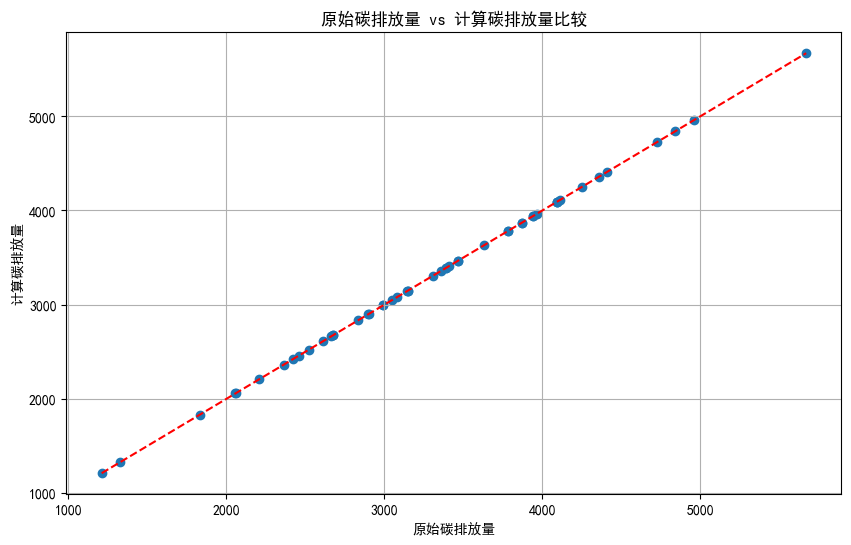

原始碳排放量和计算碳排放量的相关性: 1.0000


In [96]:
# 比较原始排放量和计算排放量
plt.figure(figsize=(10, 6))
plt.scatter(df_clean["碳排放量"], df_clean["计算排放量"])
plt.plot(
    [df_clean["碳排放量"].min(), df_clean["碳排放量"].max()],
    [df_clean["碳排放量"].min(), df_clean["碳排放量"].max()],
    "r--",
)
plt.xlabel("原始碳排放量")
plt.ylabel("计算碳排放量")
plt.title("原始碳排放量 vs 计算碳排放量比较")
plt.grid(True)
plt.show()

# 计算相关性
correlation = df_clean["碳排放量"].corr(df_clean["计算排放量"])
print(f"原始碳排放量和计算碳排放量的相关性: {correlation:.4f}")

## 3. 特征工程与模型训练

In [97]:
# 选择特征和目标变量
features = ["化石燃料活动水平", "化石燃料排放因子", "计算排放量"]
X = df_clean[features]
y = df_clean["碳排放量"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化特征 (不标准化目标变量)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

均方误差 (MSE): 85406.9829
决定系数 (R²): 0.8947


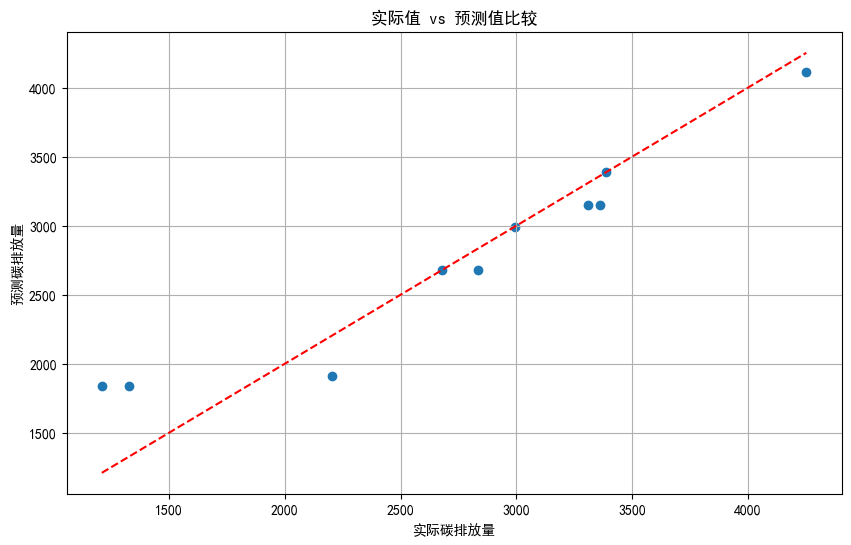

In [98]:
# 创建并训练 XGBoost 模型
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
)

# 训练模型
xgb_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred = xgb_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse:.4f}")
print(f"决定系数 (R²): {r2:.4f}")

# 显示预测结果与实际值的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("实际碳排放量")
plt.ylabel("预测碳排放量")
plt.title("实际值 vs 预测值比较")
plt.grid(True)
plt.show()

## 4. 交互式预测界面

In [99]:
# 创建预测函数
def predict_emission(活动水平, 排放因子):
    # 计算排放量
    计算排放量 = PetrochemicalEmissions.calculate_petrochemical_fossil_fuel_emission(
        活动水平, 排放因子
    )

    # 创建预测所需的特征数组
    features_input = np.zeros(3)  # 6个特征
    features_input[0] = 活动水平
    features_input[1] = 排放因子
    features_input[2] = 计算排放量

    # 标准化特征
    features_scaled = scaler.transform(features_input.reshape(1, -1))

    # 预测
    prediction = xgb_model.predict(features_scaled)[0]

    # 显示结果
    print(f"输入参数:")
    print(f"  - 化石燃料活动水平: {活动水平}")
    print(f"  - 化石燃料排放因子: {排放因子}")
    print(f"计算的初始排放量: {计算排放量:.2f}")
    print(f"模型预测的碳排放量: {prediction:.2f}")

In [100]:
# 创建交互式控件
活动水平_slider = widgets.FloatSlider(
    value=1200,
    min=400,
    max=2000,
    step=50,
    description="活动水平:",
    continuous_update=False,
)

排放因子_slider = widgets.FloatSlider(
    value=3.15,
    min=2.4,
    max=3.5,
    step=0.05,
    description="排放因子:",
    continuous_update=False,
)


# 创建输出控件
output = widgets.Output()

# 创建按钮
button = widgets.Button(
    description="预测碳排放量", button_style="success", tooltip="点击进行预测"
)


# 按钮点击事件处理函数
def on_button_clicked(b):
    with output:
        output.clear_output()
        predict_emission(活动水平_slider.value, 排放因子_slider.value)


button.on_click(on_button_clicked)

# 创建信息性标签
title = widgets.HTML(value="<h3>石油化工行业碳排放预测</h3>")
description = widgets.HTML(value="<p>请调整以下参数，然后点击预测按钮查看结果</p>")

# 显示界面
display(title, description, 活动水平_slider, 排放因子_slider, button, output)

HTML(value='<h3>石油化工行业碳排放预测</h3>')

HTML(value='<p>请调整以下参数，然后点击预测按钮查看结果</p>')

FloatSlider(value=1200.0, continuous_update=False, description='活动水平:', max=2000.0, min=400.0, step=50.0)

FloatSlider(value=3.15, continuous_update=False, description='排放因子:', max=3.5, min=2.4, step=0.05)

Button(button_style='success', description='预测碳排放量', style=ButtonStyle(), tooltip='点击进行预测')

Output()

## 5. 模型总结

本模型使用 XGBoost 算法，基于石油化工行业的化石燃料活动水平、排放因子和年份数据预测碳排放量。通过交互式界面，用户可以输入不同的参数值，获取相应的碳排放预测结果。

主要特点：
1. 利用了 utils.py 中的石油化工排放计算函数
2. 对原始数据进行了预处理，去除括号和中文描述
3. 构建了高精度的 XGBoost 预测模型
4. 提供了交互式预测界面

该模型可用于石油化工企业的碳排放预测和管理，帮助企业了解不同活动水平和排放因子下的潜在碳排放情况。